In [1]:
import warnings
warnings.filterwarnings('ignore')
import os

In [2]:
__file__ = 'Xception-8.29.3-2'
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [3]:
from keras.preprocessing.image import ImageDataGenerator
from glob import glob
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras.applications.inception_v3 import InceptionV3
from keras.applications.xception import Xception
from keras.applications.resnet50 import ResNet50
from keras_applications.resnext import ResNeXt50
from keras.applications.nasnet import NASNetLarge
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import *
import PIL
import time

def preprocess_img(x):
    x = x / 127.5
    x -= 1.
    return x

Using TensorFlow backend.


In [4]:
path_data = '../garbage_classify/train_data'
batch_size = 32
img_size = 299
img_width = img_size
img_height = img_size
random_seed = 201908
path_data_train = '../tmp/data_train/'
path_data_valid = '../tmp/data_valid/'
labels_file = '../tmp/labels_raw.csv'

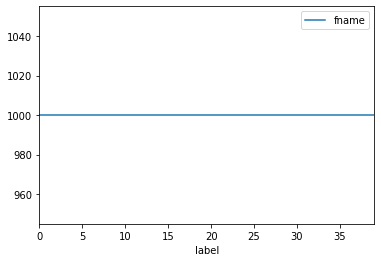

In [5]:
labels_train = pd.read_csv('../tmp/labels_train.csv')
labels_valid = pd.read_csv('../tmp/labels_valid.csv')
n_classess = labels_train.label.unique().shape[0]
labels_train.groupby(by='label').count().plot()

In [6]:
labels_train.label = labels_train.label.apply(lambda x: f'{x:02d}')
labels_valid.label = labels_valid.label.apply(lambda x: f'{x:02d}')
# labels_train['label_bin'].values = keras.utils.np_utils.to_categorical(
#     labels_train.label, n_classess)

In [7]:
ig = ImageDataGenerator(preprocessing_function=preprocess_img)

params_g = dict(
    batch_size=batch_size,
    # directory=path_data,
    # class_mode='other',
    x_col='fname',
    y_col='label',
    target_size=(img_width, img_height),
    interpolation='lanczos',
    seed=random_seed)

train_g = ig.flow_from_dataframe(
    labels_train, path_data_train, **params_g)
valid_g = ig.flow_from_dataframe(
    labels_valid, path_data_valid, **params_g)

Found 40000 validated image filenames belonging to 40 classes.
Found 2978 validated image filenames belonging to 40 classes.


In [8]:
from keras import layers
channel_axis = -1

img_input = layers.Input(shape=(img_size,img_size,3))
x = layers.Conv2D(32, (3, 3),
                  strides=(2, 2),
                  use_bias=False,
                  name='block1_conv1')(img_input)
x = layers.BatchNormalization(axis=channel_axis, name='block1_conv1_bn')(x)
x = layers.Activation('relu', name='block1_conv1_act')(x)
x = layers.Conv2D(64, (3, 3), use_bias=False, name='block1_conv2')(x)
x = layers.BatchNormalization(axis=channel_axis, name='block1_conv2_bn')(x)
x = layers.Activation('relu', name='block1_conv2_act')(x)

residual = layers.Conv2D(128, (1, 1),
                         strides=(2, 2),
                         padding='same',
                         use_bias=False)(x)
residual = layers.BatchNormalization(axis=channel_axis)(residual)

x = layers.SeparableConv2D(128, (3, 3),
                           padding='same',
                           use_bias=False,
                           name='block2_sepconv1')(x)
x = layers.BatchNormalization(axis=channel_axis, name='block2_sepconv1_bn')(x)
x = layers.Activation('relu', name='block2_sepconv2_act')(x)
x = layers.SeparableConv2D(128, (3, 3),
                           padding='same',
                           use_bias=False,
                           name='block2_sepconv2')(x)
x = layers.BatchNormalization(axis=channel_axis, name='block2_sepconv2_bn')(x)

x = layers.MaxPooling2D((3, 3),
                        strides=(2, 2),
                        padding='same',
                        name='block2_pool')(x)
x = layers.add([x, residual])

residual = layers.Conv2D(256, (1, 1), strides=(2, 2),
                         padding='same', use_bias=False)(x)
residual = layers.BatchNormalization(axis=channel_axis)(residual)

x = layers.Activation('relu', name='block3_sepconv1_act')(x)
x = layers.SeparableConv2D(256, (3, 3),
                           padding='same',
                           use_bias=False,
                           name='block3_sepconv1')(x)
x = layers.BatchNormalization(axis=channel_axis, name='block3_sepconv1_bn')(x)
x = layers.Activation('relu', name='block3_sepconv2_act')(x)
x = layers.SeparableConv2D(256, (3, 3),
                           padding='same',
                           use_bias=False,
                           name='block3_sepconv2')(x)
x = layers.BatchNormalization(axis=channel_axis, name='block3_sepconv2_bn')(x)

x = layers.MaxPooling2D((3, 3), strides=(2, 2),
                        padding='same',
                        name='block3_pool')(x)
x = layers.add([x, residual])

residual = layers.Conv2D(728, (1, 1),
                         strides=(2, 2),
                         padding='same',
                         use_bias=False)(x)
residual = layers.BatchNormalization(axis=channel_axis)(residual)

x = layers.Activation('relu', name='block4_sepconv1_act')(x)
x = layers.SeparableConv2D(728, (3, 3),
                           padding='same',
                           use_bias=False,
                           name='block4_sepconv1')(x)
x = layers.BatchNormalization(axis=channel_axis, name='block4_sepconv1_bn')(x)
x = layers.Activation('relu', name='block4_sepconv2_act')(x)
x = layers.SeparableConv2D(728, (3, 3),
                           padding='same',
                           use_bias=False,
                           name='block4_sepconv2')(x)
x = layers.BatchNormalization(axis=channel_axis, name='block4_sepconv2_bn')(x)

x = layers.MaxPooling2D((3, 3), strides=(2, 2),
                        padding='same',
                        name='block4_pool')(x)
x = layers.add([x, residual])


for i in range(6):
    residual = x
    prefix = 'block' + str(i + 5)

    x = layers.Activation('relu', name=prefix + '_sepconv1_act')(x)
    x = layers.SeparableConv2D(728, (3, 3),
                               padding='same',
                               use_bias=False,
                               name=prefix + '_sepconv1')(x)
    x = layers.BatchNormalization(axis=channel_axis,
                                  name=prefix + '_sepconv1_bn')(x)
    x = layers.Activation('relu', name=prefix + '_sepconv2_act')(x)
    x = layers.SeparableConv2D(728, (3, 3),
                               padding='same',
                               use_bias=False,
                               name=prefix + '_sepconv2')(x)
    x = layers.BatchNormalization(axis=channel_axis,
                                  name=prefix + '_sepconv2_bn')(x)
    x = layers.Activation('relu', name=prefix + '_sepconv3_act')(x)
    x = layers.SeparableConv2D(728, (3, 3),
                               padding='same',
                               use_bias=False,
                               name=prefix + '_sepconv3')(x)
    x = layers.BatchNormalization(axis=channel_axis,
                                  name=prefix + '_sepconv3_bn')(x)

    x = layers.add([x, residual])

residual = layers.Conv2D(1024, (1, 1), strides=(2, 2),
                         padding='same', use_bias=False)(x)
residual = layers.BatchNormalization(axis=channel_axis)(residual)



x = layers.Activation('relu', name='block13_old_sepconv1_act')(x)
x = layers.SeparableConv2D(728, (3, 3),
                           padding='same',
                           use_bias=False,
                           name='block13_old_sepconv1')(x)
x = layers.BatchNormalization(axis=channel_axis, name='block13_old_sepconv1_bn')(x)
x = layers.Activation('relu', name='block13_old_sepconv2_act')(x)
x = layers.SeparableConv2D(1024, (3, 3),
                           padding='same',
                           use_bias=False,
                           name='block13_old_sepconv2')(x)
x = layers.BatchNormalization(axis=channel_axis, name='block13_old_sepconv2_bn')(x)

x = layers.MaxPooling2D((3, 3),
                        strides=(2, 2),
                        padding='same',
                        name='block13_old_pool')(x)
x = layers.add([x, residual])

x = layers.SeparableConv2D(1536, (3, 3),
                           padding='same',
                           use_bias=False,
                           name='block14_old_sepconv1')(x)
x = layers.BatchNormalization(axis=channel_axis, name='block14_old_sepconv1_bn')(x)
x = layers.Activation('relu', name='block14_old_sepconv1_act')(x)

x = layers.SeparableConv2D(2048, (3, 3),
                           padding='same',
                           use_bias=False,
                           name='block14_old_sepconv2')(x)
x = layers.BatchNormalization(axis=channel_axis, name='block14_old_sepconv2_bn')(x)
x = layers.Activation('relu', name='block14_old_sepconv2_act')(x)
x = layers.GlobalAveragePooling2D(name='avg_pool')(x)

Instructions for updating:
Colocations handled automatically by placer.


In [9]:
predictions = Dense(n_classess, activation='softmax')(x)
model = Model(inputs=img_input, outputs=predictions)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

In [10]:
with open(f'../tmp/model_{__file__}.json','w') as f:
    model_json = model.to_json()
    f.write(model_json)

In [11]:
ckpt = ModelCheckpoint('../tmp/ckpt-'+__file__+'-Epoch_{epoch:03d}-acc_{acc:.5f}-val_acc_{val_acc:.5f}.h5', save_best_only=True, monitor='val_acc')

estop = EarlyStopping(monitor='val_acc', min_delta=1e-7,verbose=1, patience=20)

In [ ]:
model.compile(optimizer=Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

model.fit_generator(
    train_g,
    # steps_per_epoch=100,
    steps_per_epoch=train_g.n // batch_size,
    epochs=100,
    callbacks=[ckpt, estop],
    validation_data=valid_g,
    # validation_steps=1,
    validation_steps=valid_g.n // batch_size
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
1250/1250 [==============================] - 960s 768ms/step - loss: 3.2862 - acc: 0.1371 - val_loss: 2.9225 - val_acc: 0.2278
Epoch 2/100
1250/1250 [==============================] - 932s 746ms/step - loss: 2.8881 - acc: 0.2287 - val_loss: 2.7217 - val_acc: 0.2773
Epoch 3/100
1250/1250 [==============================] - 935s 748ms/step - loss: 2.6520 - acc: 0.2825 - val_loss: 2.4756 - val_acc: 0.3330
Epoch 4/100
1167/1250 [===========================>..] - ETA: 58s - loss: 2.4541 - acc: 0.3267